In [1]:
%pip install datasets torchsummary

/bin/bash: /opt/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision import models, transforms
from torchvision import transforms
from torchvision import models
#from datasets import load_dataset
from tqdm import tqdm
import torchvision.models as models
# from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
# from fastai.vision.all import *
# import matplotlib.pyplot as plt
#from fastai.vision.augment import Resize
from torch.utils.data import DataLoader
import numpy as np

In [3]:
path = 'imagenette2-160/'

In [4]:
# Define ImageNet normalization statistics

# Create common transformations for both training and validation
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Apply transformations directly to datasets
train_dataset = ImageFolder(root=path + '/train', transform=common_transforms)
val_dataset = ImageFolder(root=path + '/val', transform=common_transforms)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers = 8, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers = 8, pin_memory = True)

/net/dali/home/mscbio/gak147/.conda/envs/torch_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
for images, labels in train_loader:
    shape  = images.size()
    print(images.size())  # This will give you the size of the images batch
    break  # Exit after the first batch

torch.Size([64, 3, 224, 224])


In [6]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
num_classes = len(train_dataset.classes)
print(num_classes)

10


In [8]:
# Training and evaluation functions
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # torch.autograd.set_detect_anomaly(True)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradients for faster inference
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move to device

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predictions

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

In [9]:
#figure out index of last fully connected layer
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Running the baseline

In [11]:
### ORIGINAL - NO CHANGES BESIDES LAST LAYER

# Freeze all parameters first
for param in model.parameters():
    param.requires_grad = False

# model.fc = nn.Linear(model.fc.in_features, num_classes)

# for param in model.fc.parameters():
#   param.requires_grad = True

# Modify the final fully connected layer (classifier) to have 10 output classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Assuming the original last layer is at index 6

# Unfreeze the last fully connected layer (only the new last layer will be trained)
for param in model.classifier[6].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
# Set the device (either 'cuda' for GPU or 'cpu' for CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the selected device
model = model.to(device)

In [13]:
# Training loop
num_epochs = 10
train_losses = np.zeros(num_epochs)
val_accuracies = np.zeros(num_epochs)
for epoch in np.arange(num_epochs):
    train_losses[epoch] = train(model, train_loader, criterion, optimizer, device)
    val_accuracies[epoch] = evaluate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[epoch]:.4f}, Val Accuracy: {val_accuracies[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 1, Train Loss: 0.3523, Val Accuracy: 0.9343


100%|██████████| 62/62 [00:11<00:00,  5.33it/s]


Epoch 2, Train Loss: 0.1945, Val Accuracy: 0.9404


100%|██████████| 62/62 [00:11<00:00,  5.38it/s]


Epoch 3, Train Loss: 0.1654, Val Accuracy: 0.9470


100%|██████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 4, Train Loss: 0.1504, Val Accuracy: 0.9493


100%|██████████| 62/62 [00:11<00:00,  5.38it/s]


Epoch 5, Train Loss: 0.1407, Val Accuracy: 0.9501


100%|██████████| 62/62 [00:11<00:00,  5.34it/s]


Epoch 6, Train Loss: 0.1343, Val Accuracy: 0.9470


100%|██████████| 62/62 [00:11<00:00,  5.26it/s]


Epoch 7, Train Loss: 0.1280, Val Accuracy: 0.9460


100%|██████████| 62/62 [00:11<00:00,  5.37it/s]


Epoch 8, Train Loss: 0.1160, Val Accuracy: 0.9503


100%|██████████| 62/62 [00:11<00:00,  5.33it/s]


Epoch 9, Train Loss: 0.1131, Val Accuracy: 0.9485


100%|██████████| 62/62 [00:11<00:00,  5.20it/s]

Epoch 10, Train Loss: 0.1124, Val Accuracy: 0.9513


Replacing the last layer

In [15]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model2 = model

# Freeze all parameters first
for param in model2.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model2.features[28] = nn.Linear(14,14)

model2.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model2.classifier[6].parameters():
  param.requires_grad = True

for param in model2.features[28].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [17]:
model2.to(device)

summary(model2, (3, 224, 224))
model2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
num_epochs = 10
train_loss_last = np.zeros(num_epochs)
val_accuracy_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_last[epoch] = train(model2, train_loader, criterion, optimizer, device)
    val_accuracy_last[epoch] = evaluate(model2, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_last[epoch]:.4f}, Val Accuracy: {val_accuracy_last[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.19it/s]


Epoch 1, Train Loss: 1.0800, Val Accuracy: 0.8362


100%|██████████| 62/62 [00:12<00:00,  5.11it/s]


Epoch 2, Train Loss: 0.5642, Val Accuracy: 0.8690


100%|██████████| 62/62 [00:11<00:00,  5.21it/s]


Epoch 3, Train Loss: 0.4980, Val Accuracy: 0.8838


100%|██████████| 62/62 [00:11<00:00,  5.23it/s]


Epoch 4, Train Loss: 0.4599, Val Accuracy: 0.8836


100%|██████████| 62/62 [00:12<00:00,  5.11it/s]


Epoch 5, Train Loss: 0.4375, Val Accuracy: 0.8820


100%|██████████| 62/62 [00:11<00:00,  5.23it/s]


Epoch 6, Train Loss: 0.4240, Val Accuracy: 0.8882


100%|██████████| 62/62 [00:12<00:00,  5.12it/s]


Epoch 7, Train Loss: 0.4020, Val Accuracy: 0.8917


100%|██████████| 62/62 [00:11<00:00,  5.18it/s]


Epoch 8, Train Loss: 0.4001, Val Accuracy: 0.8897


100%|██████████| 62/62 [00:11<00:00,  5.26it/s]


Epoch 9, Train Loss: 0.3821, Val Accuracy: 0.8917


100%|██████████| 62/62 [00:11<00:00,  5.29it/s]

Epoch 10, Train Loss: 0.3750, Val Accuracy: 0.8930


Replacing first layer

In [19]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model3 = model

# Freeze all parameters first
for param in model3.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model3.features[2] = nn.Linear(224,224)

model3.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model3.classifier[6].parameters():
  param.requires_grad = True

for param in model3.features[2].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [21]:
model3.to(device)

summary(model3, (3, 224, 224))
model3

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [22]:
num_epochs = 10
train_loss_first = np.zeros(num_epochs)
val_accuracy_first = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first[epoch] = train(model3, train_loader, criterion, optimizer, device)
    val_accuracy_first[epoch] = evaluate(model3, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first[epoch]:.4f}, Val Accuracy: {val_accuracy_first[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.19it/s]


Epoch 1, Train Loss: 1.9974, Val Accuracy: 0.3465


100%|██████████| 62/62 [00:11<00:00,  5.17it/s]


Epoch 2, Train Loss: 1.8313, Val Accuracy: 0.3735


100%|██████████| 62/62 [00:11<00:00,  5.23it/s]


Epoch 3, Train Loss: 1.7700, Val Accuracy: 0.3980


100%|██████████| 62/62 [00:11<00:00,  5.20it/s]


Epoch 4, Train Loss: 1.7150, Val Accuracy: 0.3939


100%|██████████| 62/62 [00:11<00:00,  5.42it/s]


Epoch 5, Train Loss: 1.6805, Val Accuracy: 0.4125


100%|██████████| 62/62 [00:11<00:00,  5.24it/s]


Epoch 6, Train Loss: 1.6597, Val Accuracy: 0.4183


100%|██████████| 62/62 [00:11<00:00,  5.25it/s]


Epoch 7, Train Loss: 1.6414, Val Accuracy: 0.4566


100%|██████████| 62/62 [00:11<00:00,  5.34it/s]


Epoch 8, Train Loss: 1.6282, Val Accuracy: 0.4359


100%|██████████| 62/62 [00:11<00:00,  5.25it/s]


Epoch 9, Train Loss: 1.6123, Val Accuracy: 0.4372


100%|██████████| 62/62 [00:11<00:00,  5.25it/s]

Epoch 10, Train Loss: 1.6078, Val Accuracy: 0.4731


Replacing middle layer

In [23]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [24]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model4 = model

# Freeze all parameters first
for param in model4.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model4.features[14] = nn.Linear(56,56)

model4.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model4.classifier[6].parameters():
  param.requires_grad = True

for param in model4.features[14].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model4.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
model4.to(device)

summary(model4, (3, 224, 224))
model4

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [26]:
num_epochs = 10
train_loss_middle = np.zeros(num_epochs)
val_accuracy_middle = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middle[epoch] = train(model4, train_loader, criterion, optimizer, device)
    val_accuracy_middle[epoch] = evaluate(model4, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middle[epoch]:.4f}, Val Accuracy: {val_accuracy_middle[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.32it/s]


Epoch 1, Train Loss: 1.9031, Val Accuracy: 0.3934


100%|██████████| 62/62 [00:11<00:00,  5.29it/s]


Epoch 2, Train Loss: 1.6395, Val Accuracy: 0.4838


100%|██████████| 62/62 [00:11<00:00,  5.29it/s]


Epoch 3, Train Loss: 1.5702, Val Accuracy: 0.5085


100%|██████████| 62/62 [00:11<00:00,  5.27it/s]


Epoch 4, Train Loss: 1.5245, Val Accuracy: 0.5185


100%|██████████| 62/62 [00:11<00:00,  5.30it/s]


Epoch 5, Train Loss: 1.4885, Val Accuracy: 0.5254


100%|██████████| 62/62 [00:11<00:00,  5.33it/s]


Epoch 6, Train Loss: 1.4594, Val Accuracy: 0.5361


100%|██████████| 62/62 [00:11<00:00,  5.32it/s]


Epoch 7, Train Loss: 1.4374, Val Accuracy: 0.5282


100%|██████████| 62/62 [00:11<00:00,  5.36it/s]


Epoch 8, Train Loss: 1.4081, Val Accuracy: 0.5340


100%|██████████| 62/62 [00:14<00:00,  4.17it/s]


Epoch 9, Train Loss: 1.4111, Val Accuracy: 0.5215


100%|██████████| 62/62 [00:11<00:00,  5.27it/s]

Epoch 10, Train Loss: 1.3897, Val Accuracy: 0.5554


First and middle layers replaced

In [27]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model5 = model

# Freeze all parameters first
for param in model5.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model5.features[2] = nn.Linear(224,224)
model5.features[14] = nn.Linear(56,56)

model5.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model5.classifier[6].parameters():
  param.requires_grad = True

for param in model5.features[14].parameters():
    param.requires_grad = True

for param in model5.features[2].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model5.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
model5.to(device)

summary(model5, (3, 224, 224))
model5

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): C

In [30]:
num_epochs = 10
train_loss_first_middle = np.zeros(num_epochs)
val_accuracy_first_middle = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first_middle[epoch] = train(model5, train_loader, criterion, optimizer, device)
    val_accuracy_first_middle[epoch] = evaluate(model5, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first_middle[epoch]:.4f}, Val Accuracy: {val_accuracy_first_middle[epoch]:.4f}")

100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch 1, Train Loss: 2.1191, Val Accuracy: 0.2856


100%|██████████| 62/62 [00:11<00:00,  5.47it/s]


Epoch 2, Train Loss: 1.9322, Val Accuracy: 0.3488


100%|██████████| 62/62 [00:11<00:00,  5.53it/s]


Epoch 3, Train Loss: 1.8064, Val Accuracy: 0.4130


100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch 4, Train Loss: 1.7267, Val Accuracy: 0.4214


100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 5, Train Loss: 1.6736, Val Accuracy: 0.4515


100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch 6, Train Loss: 1.6469, Val Accuracy: 0.4436


100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch 7, Train Loss: 1.6009, Val Accuracy: 0.4558


100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Epoch 8, Train Loss: 1.5781, Val Accuracy: 0.4464


100%|██████████| 62/62 [00:11<00:00,  5.58it/s]


Epoch 9, Train Loss: 1.5662, Val Accuracy: 0.4713


100%|██████████| 62/62 [00:11<00:00,  5.63it/s]

Epoch 10, Train Loss: 1.5309, Val Accuracy: 0.4642


First and last layers replaced

In [31]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [32]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model6 = model

# Freeze all parameters first
for param in model6.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model6.features[2] = nn.Linear(224,224)
model6.features[28] = nn.Linear(14,14)

model6.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model6.classifier[6].parameters():
  param.requires_grad = True

for param in model6.features[2].parameters():
    param.requires_grad = True

for param in model6.features[28].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model6.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [33]:
model6.to(device)

summary(model6, (3, 224, 224))
model6

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Linear-3         [-1, 64, 224, 224]          50,400
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Linear(in_features=224, out_features=224, bias=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [34]:
num_epochs = 10
train_loss_first_last = np.zeros(num_epochs)
val_accuracy_first_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_first_last[epoch] = train(model6, train_loader, criterion, optimizer, device)
    val_accuracy_first_last[epoch] = evaluate(model6, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_first_last[epoch]:.4f}, Val Accuracy: {val_accuracy_first_last[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.53it/s]


Epoch 1, Train Loss: 2.3148, Val Accuracy: 0.1666


100%|██████████| 62/62 [00:11<00:00,  5.22it/s]


Epoch 2, Train Loss: 2.0421, Val Accuracy: 0.2920


100%|██████████| 62/62 [00:10<00:00,  5.74it/s]


Epoch 3, Train Loss: 1.8302, Val Accuracy: 0.3985


100%|██████████| 62/62 [00:11<00:00,  5.35it/s]


Epoch 4, Train Loss: 1.7291, Val Accuracy: 0.4115


100%|██████████| 62/62 [00:11<00:00,  5.35it/s]


Epoch 5, Train Loss: 1.6710, Val Accuracy: 0.4629


100%|██████████| 62/62 [00:11<00:00,  5.42it/s]


Epoch 6, Train Loss: 1.6258, Val Accuracy: 0.4443


100%|██████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 7, Train Loss: 1.5800, Val Accuracy: 0.4683


100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch 8, Train Loss: 1.5443, Val Accuracy: 0.4805


100%|██████████| 62/62 [00:11<00:00,  5.43it/s]


Epoch 9, Train Loss: 1.5341, Val Accuracy: 0.4815


100%|██████████| 62/62 [00:11<00:00,  5.46it/s]

Epoch 10, Train Loss: 1.5109, Val Accuracy: 0.5024


Middle and last layers replaced

In [35]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model7 = model

# Freeze all parameters first
for param in model7.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model7.features[14] = nn.Linear(56,56)
model7.features[28] = nn.Linear(14,14)

model7.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model7.classifier[6].parameters():
  param.requires_grad = True

for param in model7.features[14].parameters():
    param.requires_grad = True

for param in model7.features[28].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model7.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [37]:
model7.to(device)

summary(model7, (3, 224, 224))
model7

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Linear(in_features=56, out_features=56, bias=True)
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [38]:
num_epochs = 10
train_loss_middle_last = np.zeros(num_epochs)
val_accuracy_middle_last = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_middle_last[epoch] = train(model7, train_loader, criterion, optimizer, device)
    val_accuracy_middle_last[epoch] = evaluate(model7, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_middle_last[epoch]:.4f}, Val Accuracy: {val_accuracy_middle_last[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch 1, Train Loss: 2.3204, Val Accuracy: 0.1287


100%|██████████| 62/62 [00:10<00:00,  5.69it/s]


Epoch 2, Train Loss: 2.1448, Val Accuracy: 0.3271


100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch 3, Train Loss: 1.7625, Val Accuracy: 0.4431


100%|██████████| 62/62 [00:10<00:00,  5.73it/s]


Epoch 4, Train Loss: 1.6340, Val Accuracy: 0.4940


100%|██████████| 62/62 [00:11<00:00,  5.60it/s]


Epoch 5, Train Loss: 1.5581, Val Accuracy: 0.5246


100%|██████████| 62/62 [00:10<00:00,  5.67it/s]


Epoch 6, Train Loss: 1.4994, Val Accuracy: 0.5271


100%|██████████| 62/62 [00:11<00:00,  5.60it/s]


Epoch 7, Train Loss: 1.4588, Val Accuracy: 0.5516


100%|██████████| 62/62 [00:10<00:00,  5.66it/s]


Epoch 8, Train Loss: 1.4236, Val Accuracy: 0.5585


100%|██████████| 62/62 [00:11<00:00,  5.58it/s]


Epoch 9, Train Loss: 1.4012, Val Accuracy: 0.5511


100%|██████████| 62/62 [00:11<00:00,  5.60it/s]

Epoch 10, Train Loss: 1.3693, Val Accuracy: 0.5674


Plotting

In [39]:
import matplotlib.pyplot as plt

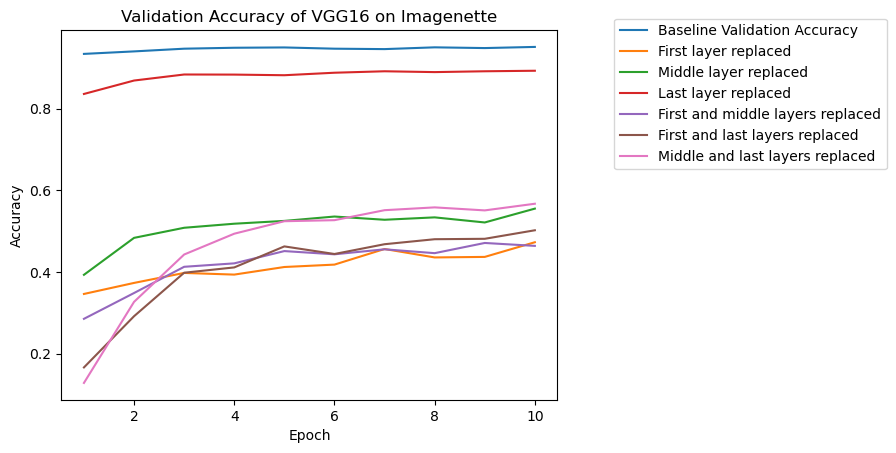

[0.93426752 0.94038217 0.94700637 0.94929936 0.95006369 0.94700637
 0.94598726 0.95031847 0.94853503 0.95133758]


In [40]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.plot(epoch, val_accuracy_first, label="First layer replaced")
plt.plot(epoch, val_accuracy_middle, label="Middle layer replaced")
plt.plot(epoch, val_accuracy_last, label="Last layer replaced")
plt.plot(epoch, val_accuracy_first_middle, label="First and middle layers replaced")
plt.plot(epoch, val_accuracy_first_last, label="First and last layers replaced")
plt.plot(epoch, val_accuracy_middle_last, label="Middle and last layers replaced")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

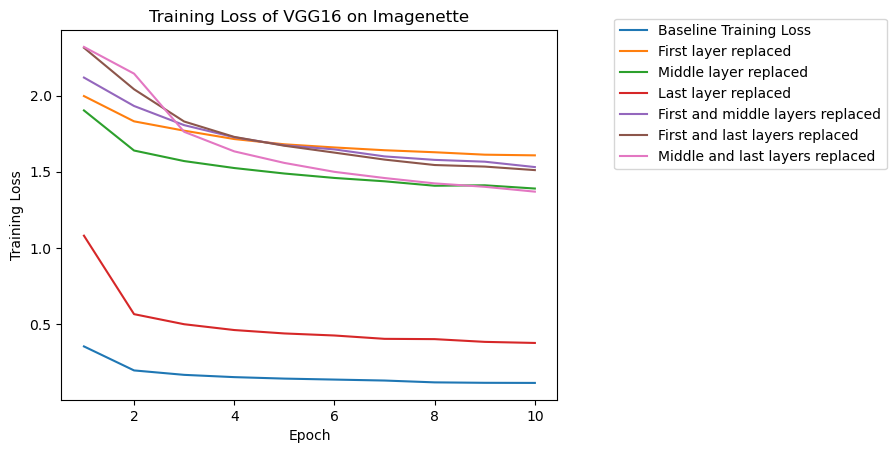

[0.35230906 0.19446474 0.16535998 0.1504167  0.14073404 0.13434324
 0.12801099 0.11597742 0.11309327 0.11235056]


In [41]:
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.plot(epoch, train_loss_first, label="First layer replaced")
plt.plot(epoch, train_loss_middle, label="Middle layer replaced")
plt.plot(epoch, train_loss_last, label="Last layer replaced")
plt.plot(epoch, train_loss_first_middle, label="First and middle layers replaced")
plt.plot(epoch, train_loss_first_last, label="First and last layers replaced")
plt.plot(epoch, train_loss_middle_last, label="Middle and last layers replaced")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# print(train_loss_changed)
print(train_losses)

## Replacing other layers outside of first, middle and last:

Replacing Conv layer 7

In [42]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model8 = model

# Freeze all parameters first
for param in model8.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model8.features[7] = nn.Linear(112,112)

model8.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model8.classifier[6].parameters():
  param.requires_grad = True

for param in model8.features[7].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model8.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [46]:
model8.to(device)

summary(model8, (3, 224, 224))
model8

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Linear-8        [-1, 128, 112, 112]          12,656
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Linear(in_features=112, out_features=112, bias=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [47]:
num_epochs = 10
train_loss_layer7 = np.zeros(num_epochs)
val_accuracy_layer7 = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_layer7[epoch] = train(model8, train_loader, criterion, optimizer, device)
    val_accuracy_layer7[epoch] = evaluate(model8, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_layer7[epoch]:.4f}, Val Accuracy: {val_accuracy_layer7[epoch]:.4f}")

  0%|          | 0/148 [00:00<?, ?it/s]/net/dali/home/mscbio/gak147/.conda/envs/torch_env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 62/62 [00:10<00:00,  5.64it/s]


Epoch 1, Train Loss: 2.0922, Val Accuracy: 0.3554


100%|██████████| 62/62 [00:10<00:00,  5.70it/s]


Epoch 2, Train Loss: 1.8655, Val Accuracy: 0.3781


100%|██████████| 62/62 [00:11<00:00,  5.61it/s]


Epoch 3, Train Loss: 1.7785, Val Accuracy: 0.4380


100%|██████████| 62/62 [00:10<00:00,  5.71it/s]


Epoch 4, Train Loss: 1.7247, Val Accuracy: 0.4288


100%|██████████| 62/62 [00:11<00:00,  5.41it/s]


Epoch 5, Train Loss: 1.6985, Val Accuracy: 0.4696


100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch 6, Train Loss: 1.6637, Val Accuracy: 0.4696


100%|██████████| 62/62 [00:11<00:00,  5.46it/s]


Epoch 7, Train Loss: 1.6360, Val Accuracy: 0.4555


100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch 8, Train Loss: 1.6203, Val Accuracy: 0.4851


100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch 9, Train Loss: 1.5992, Val Accuracy: 0.4634


100%|██████████| 62/62 [00:11<00:00,  5.35it/s]

Epoch 10, Train Loss: 1.6072, Val Accuracy: 0.4808


Replacing Conv layer 12

In [48]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model9 = model

# Freeze all parameters first
for param in model9.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model9.features[12] = nn.Linear(56,56)

model9.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model9.classifier[6].parameters():
  param.requires_grad = True

for param in model9.features[12].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model9.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [50]:
model9.to(device)

summary(model9, (3, 224, 224))
model9

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Linear-13          [-1, 256, 56, 56]           3,192
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Linear(in_features=56, out_features=56, bias=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [51]:
num_epochs = 10
train_loss_layer12 = np.zeros(num_epochs)
val_accuracy_layer12 = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_layer12[epoch] = train(model9, train_loader, criterion, optimizer, device)
    val_accuracy_layer12[epoch] = evaluate(model9, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_layer12[epoch]:.4f}, Val Accuracy: {val_accuracy_layer12[epoch]:.4f}")

100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch 1, Train Loss: 2.0902, Val Accuracy: 0.3465


100%|██████████| 62/62 [00:11<00:00,  5.60it/s]


Epoch 2, Train Loss: 1.8422, Val Accuracy: 0.3799


100%|██████████| 62/62 [00:11<00:00,  5.58it/s]


Epoch 3, Train Loss: 1.7514, Val Accuracy: 0.4517


100%|██████████| 62/62 [00:11<00:00,  5.48it/s]


Epoch 4, Train Loss: 1.7085, Val Accuracy: 0.4247


100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch 5, Train Loss: 1.6734, Val Accuracy: 0.4482


100%|██████████| 62/62 [00:11<00:00,  5.57it/s]


Epoch 6, Train Loss: 1.6429, Val Accuracy: 0.4935


100%|██████████| 62/62 [00:11<00:00,  5.45it/s]


Epoch 7, Train Loss: 1.6137, Val Accuracy: 0.4596


100%|██████████| 62/62 [00:11<00:00,  5.59it/s]


Epoch 8, Train Loss: 1.5845, Val Accuracy: 0.4989


100%|██████████| 62/62 [00:11<00:00,  5.53it/s]


Epoch 9, Train Loss: 1.5790, Val Accuracy: 0.4899


100%|██████████| 62/62 [00:11<00:00,  5.54it/s]

Epoch 10, Train Loss: 1.5576, Val Accuracy: 0.5088


Replacing Conv layer 19

In [52]:
# Load pre-trained ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
# NEW MODEL - UNFREEZING THE LAST LAYER AND CHANGING LAST CONV LAYER TO LINEAR
model10 = model

# Freeze all parameters first
for param in model10.parameters():
    param.requires_grad = False

# # replace the last conv 2d layer with a linear layer

model10.features[19] = nn.Linear(28,28)

model10.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Assuming the original last layer is at index 6


for param in model10.classifier[6].parameters():
  param.requires_grad = True

for param in model10.features[12].parameters():
    param.requires_grad = True

# # Modify inplace ReLU to non-inplace ReLU to avoid modification issues
# for i, layer in enumerate(model3.features):
#     if isinstance(layer, nn.ReLU) and layer.inplace:
#         model3.features[i] = nn.ReLU(inplace=False)
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model10.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [58]:
model10.to(device)

summary(model10, (3, 224, 224))
model10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [59]:
num_epochs = 10
train_loss_layer19 = np.zeros(num_epochs)
val_accuracy_layer19 = np.zeros(num_epochs)
for epoch in range(num_epochs):
    train_loss_layer19[epoch] = train(model10, train_loader, criterion, optimizer, device)
    val_accuracy_layer19[epoch] = evaluate(model10, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss_layer19[epoch]:.4f}, Val Accuracy: {val_accuracy_layer19[epoch]:.4f}")

100%|██████████| 62/62 [00:10<00:00,  5.69it/s]


Epoch 1, Train Loss: 1.4961, Val Accuracy: 0.6313


100%|██████████| 62/62 [00:11<00:00,  5.40it/s]


Epoch 2, Train Loss: 0.9805, Val Accuracy: 0.7330


100%|██████████| 62/62 [00:11<00:00,  5.55it/s]


Epoch 3, Train Loss: 0.7772, Val Accuracy: 0.7437


100%|██████████| 62/62 [00:11<00:00,  5.62it/s]


Epoch 4, Train Loss: 0.6619, Val Accuracy: 0.7906


100%|██████████| 62/62 [00:11<00:00,  5.59it/s]


Epoch 5, Train Loss: 0.5750, Val Accuracy: 0.7870


100%|██████████| 62/62 [00:11<00:00,  5.19it/s]


Epoch 6, Train Loss: 0.5114, Val Accuracy: 0.8117


100%|██████████| 62/62 [00:11<00:00,  5.50it/s]


Epoch 7, Train Loss: 0.4769, Val Accuracy: 0.8191


100%|██████████| 62/62 [00:10<00:00,  5.65it/s]


Epoch 8, Train Loss: 0.4186, Val Accuracy: 0.8148


100%|██████████| 62/62 [00:11<00:00,  5.56it/s]


Epoch 9, Train Loss: 0.4035, Val Accuracy: 0.8252


100%|██████████| 62/62 [00:11<00:00,  5.41it/s]

Epoch 10, Train Loss: 0.3665, Val Accuracy: 0.8283


Plotting after replacing additional layers:

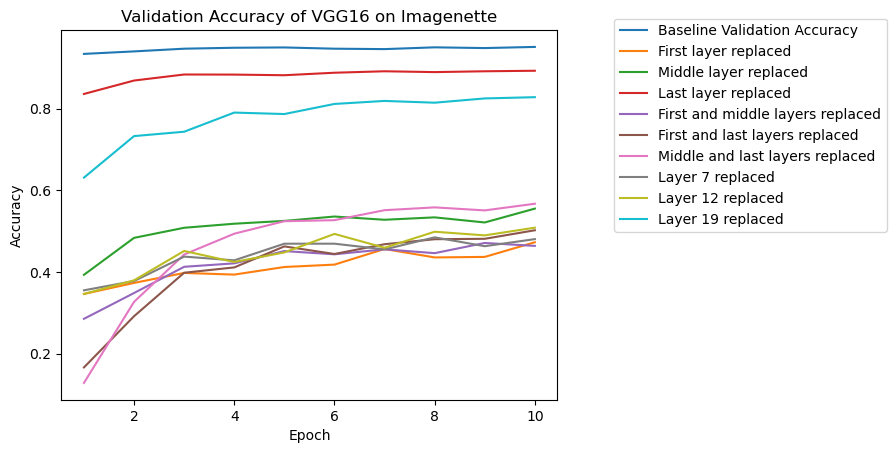

[0.93426752 0.94038217 0.94700637 0.94929936 0.95006369 0.94700637
 0.94598726 0.95031847 0.94853503 0.95133758]


In [61]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.plot(epoch, val_accuracy_first, label="First layer replaced")
plt.plot(epoch, val_accuracy_middle, label="Middle layer replaced")
plt.plot(epoch, val_accuracy_last, label="Last layer replaced")
plt.plot(epoch, val_accuracy_first_middle, label="First and middle layers replaced")
plt.plot(epoch, val_accuracy_first_last, label="First and last layers replaced")
plt.plot(epoch, val_accuracy_middle_last, label="Middle and last layers replaced")
plt.plot(epoch, val_accuracy_layer7, label="Layer 7 replaced")
plt.plot(epoch, val_accuracy_layer12, label="Layer 12 replaced")
plt.plot(epoch, val_accuracy_layer19, label="Layer 19 replaced")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

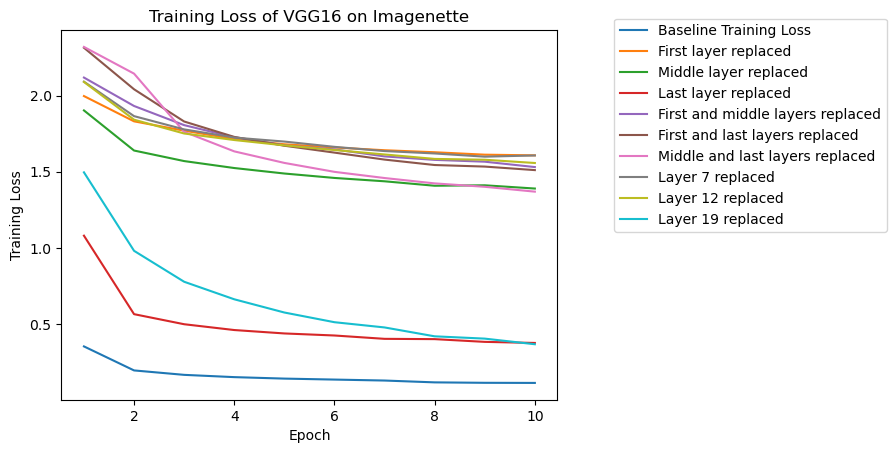

[0.35230906 0.19446474 0.16535998 0.1504167  0.14073404 0.13434324
 0.12801099 0.11597742 0.11309327 0.11235056]


In [62]:
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.plot(epoch, train_loss_first, label="First layer replaced")
plt.plot(epoch, train_loss_middle, label="Middle layer replaced")
plt.plot(epoch, train_loss_last, label="Last layer replaced")
plt.plot(epoch, train_loss_first_middle, label="First and middle layers replaced")
plt.plot(epoch, train_loss_first_last, label="First and last layers replaced")
plt.plot(epoch, train_loss_middle_last, label="Middle and last layers replaced")
plt.plot(epoch, train_loss_layer7, label="Layer 7 replaced")
plt.plot(epoch, train_loss_layer12, label="Layer 12 replaced")
plt.plot(epoch, train_loss_layer19, label="Layer 19 replaced")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# print(train_loss_changed)
print(train_losses)

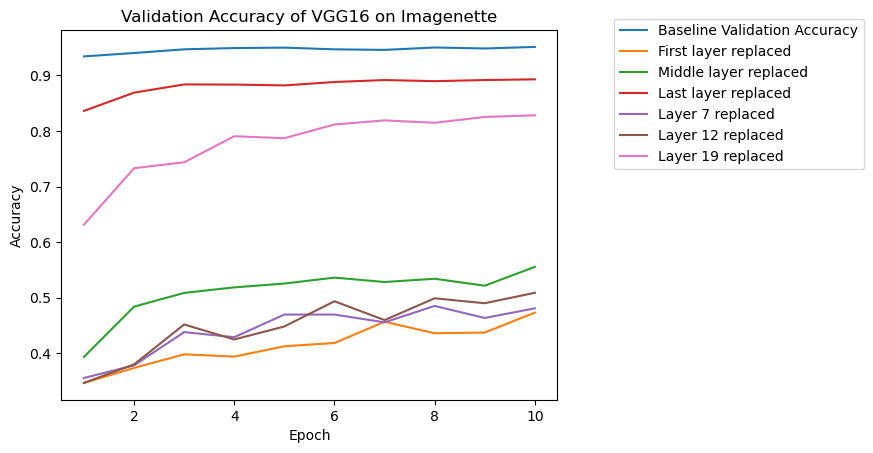

[0.93426752 0.94038217 0.94700637 0.94929936 0.95006369 0.94700637
 0.94598726 0.95031847 0.94853503 0.95133758]


In [63]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.plot(epoch, val_accuracy_first, label="First layer replaced")
plt.plot(epoch, val_accuracy_middle, label="Middle layer replaced")
plt.plot(epoch, val_accuracy_last, label="Last layer replaced")
plt.plot(epoch, val_accuracy_layer7, label="Layer 7 replaced")
plt.plot(epoch, val_accuracy_layer12, label="Layer 12 replaced")
plt.plot(epoch, val_accuracy_layer19, label="Layer 19 replaced")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

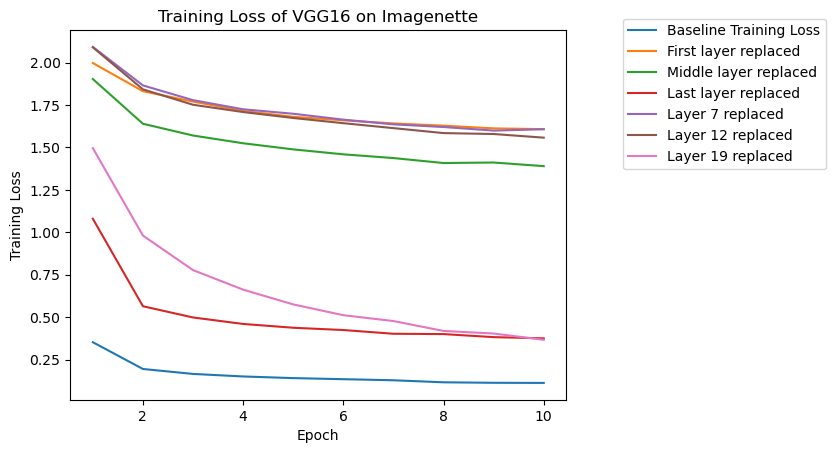

[0.35230906 0.19446474 0.16535998 0.1504167  0.14073404 0.13434324
 0.12801099 0.11597742 0.11309327 0.11235056]


In [64]:
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.plot(epoch, train_loss_first, label="First layer replaced")
plt.plot(epoch, train_loss_middle, label="Middle layer replaced")
plt.plot(epoch, train_loss_last, label="Last layer replaced")
plt.plot(epoch, train_loss_layer7, label="Layer 7 replaced")
plt.plot(epoch, train_loss_layer12, label="Layer 12 replaced")
plt.plot(epoch, train_loss_layer19, label="Layer 19 replaced")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# print(train_loss_changed)
print(train_losses)

## Original plotting:

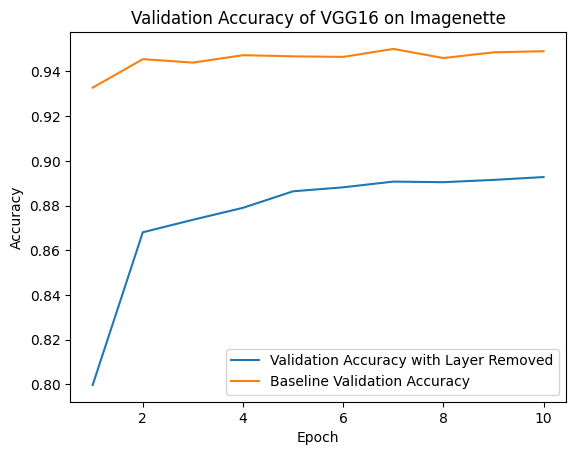

[0.93273885 0.94547771 0.94394904 0.94726115 0.94675159 0.94649682
 0.95006369 0.94598726 0.94853503 0.94904459]


In [25]:
#code for plotting the graphs below - just copy-pasted the val and training values into lists
epoch = [i for i in range(1,num_epochs+1)]
plt.plot(epoch, val_accuracy_changed_correct, label="Validation Accuracy with Layer Removed")
plt.plot(epoch, val_accuracies, label="Baseline Validation Accuracy")
plt.title("Validation Accuracy of VGG16 on Imagenette")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.show()
# print(val_accuracy_changed)
print(val_accuracies)

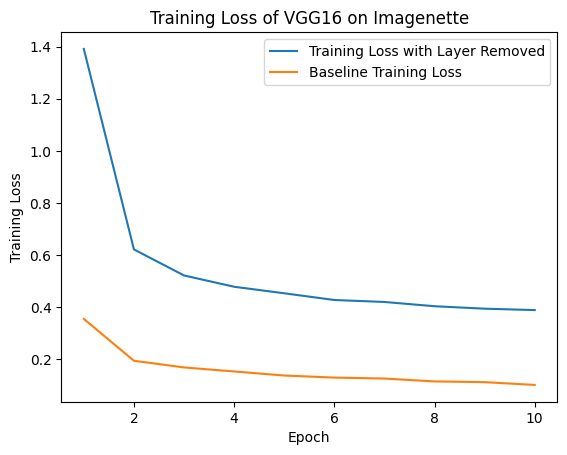

[0.35551925 0.1950045  0.16939413 0.15396993 0.13841327 0.13048469
 0.12684698 0.11576093 0.11293987 0.10235216]


In [26]:
plt.plot(epoch, train_loss_changed_correct, label="Training Loss with Layer Removed")
plt.plot(epoch, train_losses, label="Baseline Training Loss")
plt.title("Training Loss of VGG16 on Imagenette")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# print(train_loss_changed)
print(train_losses)